## Imports

In [8]:
import numpy as np
from skimage import io
import random
import cv2 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys
from importlib import reload

from MNIST import MNIST
from matplotlib import pyplot as plt
from skimage import io
from skimage.util import random_noise

from sklearn.model_selection import train_test_split

In [23]:
scale              = 1
progress_verbosity = 1
dataset_seed     = 123

clean_data, class_data = MNIST.get_origine(scale=scale)

Dataset loaded.
Normalized.
Reshaped.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)


In [9]:
def noise_it(data):
    new_data = np.copy(data)
    for i,image in enumerate(new_data):
        image=random_noise(image, mode='gaussian', mean=0, var=0.3)
        image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        image=random_noise(image, mode='poisson') 
        image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        new_data[i]=image
    print('Done.')
    return new_data
noisy_data = noise_it(clean_data)

Done.


In [11]:
print('Clean dataset (clean_data) : ',clean_data.shape)
print('Noisy dataset (noisy_data) : ',noisy_data.shape)

Clean dataset (clean_data) :  (70000, 28, 28, 1)
Noisy dataset (noisy_data) :  (70000, 28, 28, 1)


In [12]:
p = np.random.permutation(len(clean_data))
clean_data, noisy_data, class_data = clean_data[p], noisy_data[p], class_data[p]

In [20]:
%ls

AE-Copy1.ipynb  mnist-noisy.h5  MNIST.py  __pycache__/


In [21]:
prepared_dataset   = './mnist-noisy.h5'

MNIST.save_prepared_dataset( clean_data, noisy_data, class_data, filename=prepared_dataset )

Saved.
clean_data shape is :  (70000, 28, 28, 1)
noisy_data shape is :  (70000, 28, 28, 1)
class_data shape is :  (70000,)


In [24]:
clean_train,clean_test, noisy_train,noisy_test, _,_ = MNIST.reload_prepared_dataset(scale      = scale, 
                                                                                    train_prop = train_prop,
                                                                                    seed       = dataset_seed,
                                                                                    shuffle    = True,
                                                                                    filename=prepared_dataset )

Loaded.
rescaled (1).
Seeded (123)
Shuffled.
splited (0.8).
clean_train shape is :  (56000, 28, 28, 1)
clean_test  shape is :  (14000, 28, 28, 1)
noisy_train shape is :  (56000, 28, 28, 1)
noisy_test  shape is :  (14000, 28, 28, 1)
class_train shape is :  (56000,)
class_test  shape is :  (14000,)
Blake2b digest is    :  ea342fd2af7361d595a3


## Base de données

### Pretraitement

## Modele

#### Encoder

In [13]:
latent_dim = 2
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 16)                50192     
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 69,042
Trainable params: 69,042
Non-trainable

2022-11-28 15:24:35.001476: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-28 15:24:35.001525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (si30): /proc/driver/nvidia/version does not exist
2022-11-28 15:24:35.002191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Decoder

In [14]:

inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

#### AE


In [32]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')
# ae.compile(loss='mean_squared_error', optimizer='adam')

## Entrainement

In [33]:
scale            = .1

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 4
fit_verbosity    = 1

history = ae.fit(noisy_train, clean_train,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noisy_test, clean_test)  )

Epoch 1/4
438/438 [==============================] - 40s 88ms/step - loss: 0.0499 - val_loss: 0.0492
Epoch 2/4
438/438 [==============================] - 48s 109ms/step - loss: 0.0490 - val_loss: 0.0487
Epoch 3/4
438/438 [==============================] - 56s 129ms/step - loss: 0.0483 - val_loss: 0.0480
Epoch 4/4
438/438 [==============================] - 40s 92ms/step - loss: 0.0477 - val_loss: 0.0476


## Resultats (Prediction)

1750/1750 [==============================] - 4s 2ms/step


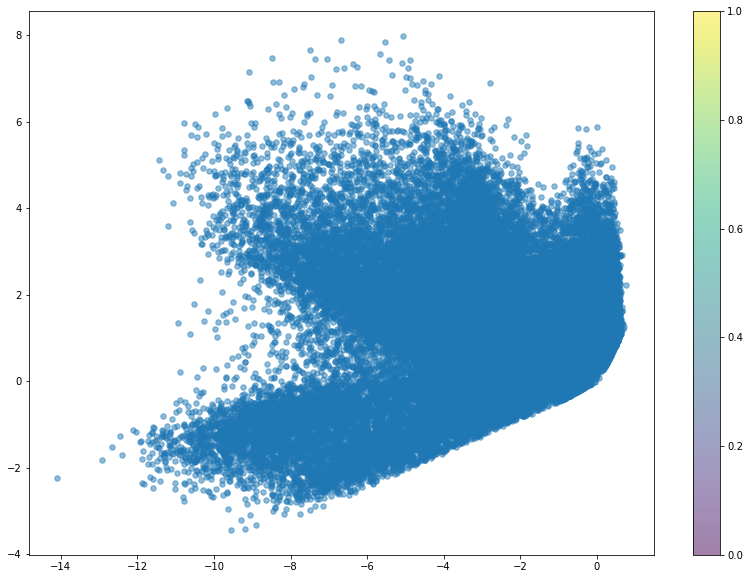

In [28]:
model = ae
encoder=model.get_layer('encoder')


# ---- Get latent points

z = encoder.predict(noisy_train)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
# fidle.scrawler.save_fig('08-Latent-space')
plt.show()

In [ ]:
print(model.get_layer('encoder'))
print(model.get_layer('decoder'))

1/1 [==============================] - 0s 114ms/step


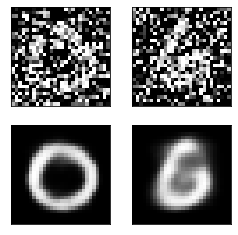

In [30]:
IMG_SIZE = 28
to_predict = noisy_train[:2]
predicted = ae.predict(to_predict.reshape(-1, IMG_SIZE, IMG_SIZE, 1))
nrows=2
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(4,4))
for images, row in zip([to_predict, predicted], axes):
    for img, ax in zip(images, row):
        img = img*255
        ax.imshow(img.reshape((IMG_SIZE, IMG_SIZE)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Generate degraged photos
